In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


from scfw.scopt import scopt
import scfw.phase_retrival as pr

# TODO
1. vectorize phase functions
2. add extra params to acelerate

## Data load

In [2]:
data_folder = '../../data/'
problem_name = 'phase_data_128_32'
results = {problem_name: {}}

In [3]:
# load data
with open(os.path.join(data_folder, problem_name + '.pckl'), 'rb') as f:
    data = pickle.load(f)
    
a = data['a']
x_sol = data['x_sol']
x_0 = data['x_0']

for i in range(a.shape[0]):
    a[i,:]=a[i,:]/np.linalg.norm(a[i,:])
A = np.array([np.dot(a_i.reshape(-1, 1), np.conj(a_i).reshape(1, -1)) for a_i in a])
X_sol = np.dot(x_sol.reshape(-1, 1), np.conj(x_sol).reshape(1, -1))
X_0 = np.dot(x_0.reshape(-1, 1), np.conj(x_0).reshape(1, -1))

lambda_val = [pr.norm(np.vdot(a_i, x_sol))**2 for a_i in a]
np.random.seed(1)
y = np.array([np.random.poisson(lambda_i) for lambda_i in lambda_val])

#y = data['y']
c = np.mean(y)
print(c,sum(np.diag(X_sol.real)))
c=300 #in order to use the above estimation we need n>>p

10.96875 254.62122087164187


## Parameters initialization

In [4]:
#first set of parameters
Mf = 2
nu = 3
#running parameters

terminate_tol = 1e-10

FW_params={
    'iter_FW': 50000,
    'line_search_tol': 1e-10,
}


sc_params={
    #parameters for SCOPT
    'iter_SC': 1000,
    'Lest': 'estimate', #estimate L
    'use_two_phase': True,
    #FISTA parameters
    'fista_type': 'mfista',
    'fista_tol': 1e-5,
    'fista_iter': 1000,
    #Conjugate Gradient Parameters
    'conj_grad_tol': 1e-2,
    'conj_grad_iter': 100,
}

# Auxilary functions

In [5]:
func_x = lambda X: pr.phase_val(A, X, y)
grad_x = lambda X, trace_sum: pr.phase_gradient(A, X, y, trace_sum)
#grad_beta = lambda x, s, beta, dot_product, dot_product_s: ps.grad_poisson(W, y, lam, (1 - beta) * x + beta * s, (1 - beta) * dot_product + beta * dot_product_s)
hess_mult_x = lambda S, trace_sum: pr.hess_mult(A, y, S, trace_sum)
hess_mult_vec_x = lambda S, trace_sum: pr.hess_mult_vec(A, y, S, trace_sum)
#extra_func = lambda x: W @ x
#linear_orcale = lambda grad: ps.linear_oracle_full_simplex(grad, M)
prox_func = lambda X, L: pr.proj_map(X, c) #used for SCOPT

## Run SCOPT

In [6]:
 X, alpha_hist, Q_hist, time_hist, grad_hist = scopt(func_x,
          grad_x,
          hess_mult_x,
          hess_mult_vec_x,
          Mf,
          nu,
          prox_func,
          X_0,  
          sc_params,                                              
          eps=terminate_tol,                                              
          print_every=1)
    
results[problem_name]['scopt'] = {
    'x': X,
    'alpha_hist': alpha_hist,
    #'Gap_hist': Gap_hist,
    'Q_hist': Q_hist,
    'time_hist': time_hist,
    'grad_hist': grad_hist
}

iter =    1, stepsize = 5.556e-02, rdiff = 1.892e-01 , f = -1.67902

iter =    2, stepsize = 5.574e-02, rdiff = 2.007e-01 , f = -18.0353

iter =    3, stepsize = 5.593e-02, rdiff = 2.118e-01 , f = -34.3469

iter =    4, stepsize = 5.612e-02, rdiff = 2.222e-01 , f = -50.605

iter =    5, stepsize = 5.632e-02, rdiff = 2.315e-01 , f = -66.8003

iter =    6, stepsize = 5.653e-02, rdiff = 2.377e-01 , f = -82.923

iter =    7, stepsize = 5.673e-02, rdiff = 2.410e-01 , f = -98.9615

iter =    8, stepsize = 5.688e-02, rdiff = 3.563e-02 , f = -114.907

iter =    9, stepsize = 5.707e-02, rdiff = 2.518e-01 , f = -130.142

iter =   10, stepsize = 5.704e-02, rdiff = 3.904e-02 , f = -145.918

iter =   11, stepsize = 5.753e-02, rdiff = 2.565e-01 , f = -161.015

iter =   12, stepsize = 5.807e-02, rdiff = 2.507e-01 , f = -176.601

iter =   13, stepsize = 5.739e-02, rdiff = 4.483e-02 , f = -192.069

iter =   14, stepsize = 5.856e-02, rdiff = 2.483e-01 , f = -206.945

iter =   15, stepsize = 5.889e-02, r

286.61859852844407
-462.68970154617597
-755.0973151290982


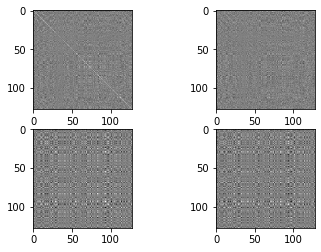

In [7]:
plt.subplot(2, 2, 1)
plt.imshow(X.real,cmap='gray',vmin=-10,vmax=10)
plt.subplot(2, 2, 2)
plt.imshow(X.imag,cmap='gray',vmin=-10,vmax=10)
plt.subplot(2, 2, 3)
plt.imshow(X_sol.real,cmap='gray',vmin=-10,vmax=10)
plt.subplot(2, 2, 4)
plt.imshow(X_sol.imag,cmap='gray',vmin=-10,vmax=10)
print(np.linalg.norm(X_sol-X))
print(func_x(X_sol)[0])
print(func_x(X)[0])